# Practice Neighborhood Analysis of Toronto

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re
import time
import json
import requests
from bs4 import BeautifulSoup
from pandas import json_normalize

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import geopy.geocoders
from geopy.geocoders import ArcGIS
import folium

from sklearn.cluster import KMeans

## Part 1: Parse Toronto Neighborhood Data into DataFrame

First, we request the page from wikipedia, and parse it into a HTML tree using BeautifulSoup. This allows us to move through the tree with ~~relative~~ ease.

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'lxml')

All the neighborhood data is stored as table entries; we can find them by taking all the items tagged with `<td>`. We only need the first 180 entries, as there are only 180 entries in the actual postal code table. 

In [3]:
hood_table = soup.find_all('td')[:180]

Let's look at one of these entries to see where all the information we want is stored. Remember, we want to find the PostalCode, Borough, and Neighborhood.

In [4]:
hood_table[4]

<td style="width:11%; vertical-align:top;">
<p><b>M5A</b><br/><span style="font-size:80%;"><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a><br/>(<a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a> / <a class="mw-redirect" href="/wiki/Harbourfront,_Toronto" title="Harbourfront, Toronto">Harbourfront</a>)</span>
</p>
</td>

This entry is for code M5A. According to wikipedia, this is the Downtown Toronto Borough, and its neighborhoods are Regent Park and Harbourfront. We can see that this data is in this cell, buffered by hyperlinks, but that isn't always the case. How else can we get all the actual information, without dealing with all the HTML metadata? Using the `get_text` method!

(Let us also use `strip` to avoid dealing with newline characters.)

In [5]:
hood_example = hood_table[4].get_text().strip()
hood_example

'M5ADowntown Toronto(Regent Park / Harbourfront)'

Now, this is much better! This allows us to clearly see where everything in the string is.
 
 - The first three characters are the postal code.
 - The word outside the parenthesis is the borough.
 - The words inside the parentheses are the neighborhoods.

Using this, we can parse out the useful data from this string

In [6]:
postal_ex = hood_example[:3]
hood_split = hood_example[3:].strip(')').split('(')

borough_ex = hood_split[0]
neighborhoods_ex = hood_split[1].split(' / ')

print(f'The postal code is {postal_ex}')
print(f'The borough is {borough_ex}')
print(f'The neighborhoods are {neighborhoods_ex}')

The postal code is M5A
The borough is Downtown Toronto
The neighborhoods are ['Regent Park', 'Harbourfront']


Yay! We can parse the table!

Wait, before we celebrate, let's make sure this works in some other cases

In [7]:
hood_example = hood_table[2].get_text().strip()

postal_ex = hood_example[:3]
hood_split = hood_example[3:].strip(')').split('(')

borough_ex = hood_split[0]
neighborhoods_ex = hood_split[1].split(' / ')

print(f'The postal code is {postal_ex}')
print(f'The borough is {borough_ex}')
print(f'The neighborhoods are {neighborhoods_ex}')

The postal code is M3A
The borough is North York
The neighborhoods are ['Parkwoods']


Yay! It still works!

What happens if we pass in a table where the borough is not assigned?

In [8]:
hood_example = hood_table[1].get_text().strip()

postal_ex = hood_example[:3]
hood_split = hood_example[3:].strip(')').split('(')

try:
    borough_ex = hood_split[0]
    neighborhoods_ex = hood_split[1].split(' / ')
    print(f'The postal code is {postal_ex}')
    print(f'The borough is {borough_ex}')
    print(f'The neighborhoods are {neighborhoods_ex}')

except IndexError:
    print('Index Error thrown :(')

Index Error thrown :(


Oh, it throws an IndexError. That's fine, because now we can build a function to parse each table entry for us, using error handling to detect whether the borough isn't assigned. Note that M7A is a bit of a special case, as it is the only valid entry without neighborhood names in parentheses.

In [9]:
def parse_entry(entry):
    '''
    Takes in an Bs4 Tag as input and parses it in 
    the aforementioned manner. Return the postal code, 
    borough, and neighborhoods, or nothing if they are not assigned.
    Additionally, we perform some extra charcter stripping to make 
    sure no badly formatted data gets through.
    '''
    hood_entry = entry.get_text().strip()

    postal = hood_entry[:3]
    hood_split = hood_entry[3:].strip(')').split('(')
    
    borough = hood_split[0]

    try:
        neighborhoods = hood_split[1].split(' / ')
        return postal, borough, [n.split(')')[0] for n in neighborhoods]
    
    except IndexError: # Thrown if borough is not assigned.
        if postal == 'M7A': # Catch aforementioned special case
            return postal, borough.split(' / ')[0], borough.split(' / ')
        
        return postal, None, None

Let's try this out!

In [10]:
parse_entry(hood_table[4])

('M5A', 'Downtown Toronto', ['Regent Park', 'Harbourfront'])

In [11]:
parse_entry(hood_table[1])

('M2A', None, None)

Nice! Now, let's use this to assemble the table data into a nice dataframe that we can all be proud of.

In [12]:
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

toronto_df = pd.DataFrame(columns=column_names)
toronto_df

,PostalCode,Borough,Neighborhood


In [13]:
for entry in hood_table:
    postal, borough, neighborhoods = parse_entry(entry)
    
    if borough is None: continue # skips entries with no borough
    
    toronto_df = toronto_df.append(
        {'PostalCode': postal,
         'Borough': borough,
         'Neighborhood': ', '.join(neighborhoods)
        },
        ignore_index=True
    )

In [14]:
toronto_df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [15]:
print('The dataset has {} entries with {} columns'.format(*toronto_df.shape))

The dataset has 103 entries with 3 columns


Awesome!

## Part 2: Adding Coordinate Data

Now, we need to add the lattitude and longitude for each postal code. This is easy to do with geopy's geocoders!

In [16]:
geopy.geocoders.options.default_timeout = None
geolocator = ArcGIS()

In [17]:
def lookup_generator(df):
    '''
    Generates a series of postal code lookups for us to 
    use in geolocating the boroughs.
    '''
    for code in df['PostalCode']:
        yield f'{code}, Toronto, Ontario'

def lookup_wrapper(search):
    '''
    Wraps the geopy geocode function to just return
    the lattitude and longitude.
    '''
    _, (lat, long) = geolocator.geocode(search)
    return lat, long

In [18]:
# Lookup the lattitude and longitude pairs 
# for all the postal codes in our dataset.

lat_long = map(lookup_wrapper, lookup_generator(toronto_df))
lats, longs = zip(*lat_long)

In [19]:
# add lattitude and longitude columns to dataframe

toronto_df['Latitude'] = lats
toronto_df['Longitude'] = longs

toronto_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752420,-79.329242
1,M4A,North York,Victoria Village,43.730600,-79.313265
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650295,-79.359166
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723270,-79.451286
4,M7A,Queen's Park,"Queen's Park, Ontario Provincial Government",43.661150,-79.391715
5,M9A,Etobicoke,Islington Avenue,43.662299,-79.528195
6,M1B,Scarborough,"Malvern, Rouge",43.811525,-79.195517
7,M3B,North York,Don Mills,43.749055,-79.362227
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.707535,-79.311773
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657363,-79.378180


In [20]:
toronto_df['Borough'].value_counts()

North York                                                      24
Downtown Toronto                                                17
Scarborough                                                     17
Etobicoke                                                       11
Central Toronto                                                  9
West Toronto                                                     6
York                                                             5
East Toronto                                                     4
East York                                                        4
MississaugaCanada Post Gateway Processing Centre                 1
Downtown TorontoStn A PO Boxes25 The Esplanade                   1
Queen's Park                                                     1
East YorkEast Toronto                                            1
East TorontoBusiness reply mail Processing Centre969 Eastern     1
EtobicokeNorthwest                                            

## Part 3: Data Visualization and Analysis of Toronto Neighborhoods

Now, we will try to use our neighborhood dataset and some Foursquare data to draw conclusions about the neighborhoods in Toronto

In [21]:
latitude, longitude = lookup_wrapper('Toronto, Ontario')

map_toronto = folium.Map(location=(latitude, longitude), zoom_start = 10)

for lat, lng in zip(toronto_df['Latitude'], toronto_df['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto

Whoa! That's a lot of neighborhoods! Let's try only looking at the Old Toronto boroughs instead.

In [22]:
toronto_filtered = toronto_df[
    (toronto_df['Borough'] == 'Downtown Toronto') |
    (toronto_df['Borough'] == 'Central Toronto') |
    (toronto_df['Borough'] == 'West Toronto') |
    (toronto_df['Borough'] == 'East Toronto')
].reset_index(drop=True)
print(f'The filtered dataset has {toronto_filtered.shape[0]} rows.')
toronto_filtered.head(5)

The filtered dataset has 36 rows.


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650295,-79.359166
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657363,-79.378180
2,M5C,Downtown Toronto,St. James Town,43.651210,-79.375481
3,M4E,East Toronto,The Beaches,43.676531,-79.295425
4,M5E,Downtown Toronto,Berczy Park,43.645160,-79.373675


In [23]:
map_toronto_filtered = folium.Map(location=(latitude, longitude), zoom_start = 11)

for lat, lng in zip(toronto_filtered['Latitude'], toronto_filtered['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_filtered)

map_toronto_filtered

That looks much better. Now, let's try out an example call to the Foursquare API to formalize our method for retriving venue data in, say, M5A, which is Regent Park/Harbourfront.

In [24]:
m5a_lat, m5a_long = toronto_filtered.loc[0, ['Latitude', 'Longitude']]

CLIENT_ID = '34D1YPS0PXJOOPO3REYJDXPPTCOUYHCO53L55FDUEACHMDIX'
CLIENT_SECRET = 'Z2L254FJLXQAMSGZQ3NKDEYAMFUZDZGOZFDHQRUAN3Z1VK30'
VERSION = '20200321'

RADIUS, LIMIT = 500, 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    m5a_lat, 
    m5a_long,
    RADIUS, 
    LIMIT)

Now, let's send the GET request and take a look at our results.

In [25]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e764f4502a1720020b4df4e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'The Distillery District',
  'headerFullLocation': 'The Distillery District, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 40,
  'suggestedBounds': {'ne': {'lat': 43.65479500450003,
    'lng': -79.35295813298289},
   'sw': {'lat': 43.645794995500026, 'lng': -79.36537331301709}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c05ef964a520bff620e3',
       'name': 'The Distillery Historic District',
       'location': {'address': 'btwn Front, Cherry, Gardiner & Parliament',
        'lat': 43.65024435658077,
        'lng': -79.35932278633118

So, we've gotten 40 results from this query. Let's use a variant of the get_category_type function from the Foursquare lab to extract all the information we need into a DataFrame.

In [26]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if not categories_list:
        return None
    
    return categories_list[0]['name']

In [27]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)
nearby_venues = nearby_venues[['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(f'The cleaned dataset has {nearby_venues.shape[0]} entries.')
nearby_venues.head()

The cleaned dataset has 40 entries.


,name,categories,lat,lng
0,The Distillery Historic District,Historic Site,43.650244,-79.359323
1,Arvo,Coffee Shop,43.649963,-79.361442
2,Distillery Sunday Market,Farmers Market,43.650075,-79.361832
3,Cacao 70,Dessert Shop,43.650067,-79.360723
4,SOMA chocolatemaker,Chocolate Shop,43.650622,-79.358127


This is good news! As expected, we got 40 results, and were able to pull the venue name and category for the postal code. Now, we can automate this process by wrapping all this logic into one function and pull all the venue data for Old Toronto.

In [28]:
def get_nearby_venues(names, latitudes, longitudes, radius=RADIUS, limit=LIMIT):
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            limit)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name,
            lat,
            lng,
            venue['venue']['name'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories'][0]['name']) for venue in results
        ])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood',
        'Neighborhood Latitude',
        'Neighborhood Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue Category'
    ]
    
    return nearby_venues

In [29]:
toronto_venues = get_nearby_venues(toronto_filtered['Neighborhood'], 
                                   toronto_filtered['Latitude'], 
                                   toronto_filtered['Longitude'])

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church 

In [30]:
print(f'The venue dataset has {toronto_venues.shape[0]} entries.')
toronto_venues.head()

The venue dataset has 1558 entries.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.650295,-79.359166,The Distillery Historic District,43.650244,-79.359323,Historic Site
1,"Regent Park, Harbourfront",43.650295,-79.359166,Arvo,43.649963,-79.361442,Coffee Shop
2,"Regent Park, Harbourfront",43.650295,-79.359166,Distillery Sunday Market,43.650075,-79.361832,Farmers Market
3,"Regent Park, Harbourfront",43.650295,-79.359166,Cacao 70,43.650067,-79.360723,Dessert Shop
4,"Regent Park, Harbourfront",43.650295,-79.359166,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop


In [31]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,62,62,62,62,62,62
"Brockton, Parkdale Village, Exhibition Place",72,72,72,72,72,72
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",67,67,67,67,67,67
Central Bay Street,96,96,96,96,96,96
Christie,11,11,11,11,11,11
Church and Wellesley,86,86,86,86,86,86
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,30,30,30,30,30,30
Davisville North,9,9,9,9,9,9


How many unique categories of places are there?

In [32]:
print(f"There are {len(toronto_venues['Venue Category'].unique())} unique categories")


There are 224 unique categories


## Part 3B: Analyze each neighborhood

Now, lets perform a one-hot encoding of the neighborhoods, transform counts into ratios, and build a dataframe with the top 5 most commmon venue types. Notice that, for neighborhoods with fewer than 5 venues, only the first k entries will have non-zero frequency, where k is that neighborhoods'number of venues.

In [33]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.insert(0, "Neighborhoods", toronto_venues['Neighborhood'].to_list(), True)

print(toronto_onehot.shape)
toronto_onehot.head()


(1558, 225)


,Neighborhoods,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
toronto_grouped = toronto_onehot.groupby('Neighborhoods').mean().reset_index()
toronto_grouped.head()

,Neighborhoods,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Berczy Park,0.0,0.0,0.000000,0.0,0.016129,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.016129,0.032258,0.000000,0.000000,0.016129,0.032258,0.0,0.0,0.016129,0.0,0.0,0.000000,0.0,0.000000,0.0,0.032258,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.016129,0.032258,0.0,0.000000,0.000000,0.032258,0.000000,0.0,0.0,0.000000,0.000000,0.032258,0.080645,0.0,0.000000,0.0,0.0,0.016129,0.000000,0.016129,0.0,0.016129,0.016129,0.0,0.0,0.0,0.0,0.016129,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.016129,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.032258,0.000000,0.000000,0.016129,0.0,0.000000,0.000000,0.0,0.0,0.016129,0.016129,0.016129,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016129,0.016129,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.032258,0.000000,0.

In [35]:
def most_common_venues(row, topk=5):
    return row.iloc[1:].sort_values(ascending=False).index.values[:topk]
    

In [36]:
num_top_venues = 5
columns = ["Neighborhood", "Top 1st", "Top 2nd", "Top 3rd", "Top 4th", "Top 5th"]

neighborhoods = pd.DataFrame(columns=columns)
neighborhoods['Neighborhood'] = toronto_grouped['Neighborhoods']

for idx in range(toronto_grouped.shape[0]):
    neighborhoods.iloc[idx, 1:] = most_common_venues(toronto_grouped.iloc[idx, :], num_top_venues)

print(neighborhoods.shape)
neighborhoods.head()
    

(35, 6)


,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th
0,Berczy Park,Coffee Shop,Seafood Restaurant,Restaurant,Beer Bar,Bakery
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Restaurant,Furniture / Home Store,Bar
2,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Italian Restaurant,Restaurant,Café,Bar
3,Central Bay Street,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bubble Tea Shop,Plaza
4,Christie,Café,Grocery Store,Playground,Coffee Shop,Italian Restaurant


## Part 3C: Cluster Neighborhoods

Finally, we will use this data to cluster, visualize, and analyze the neighborhoods of Toronto. Don't worry, we're almost done!

In [37]:
n_clusters = 4# We made the filtered dataset out of only four boroughs.

toronto_clusters = toronto_grouped.drop('Neighborhoods', 1)

kmeans = KMeans(n_clusters=n_clusters, random_state = 0).fit(toronto_clusters)

kmeans.labels_[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Hmm, that seems strangely homogenous. Let's take some bar plots of the label distribution for different values of K to see what's going on.

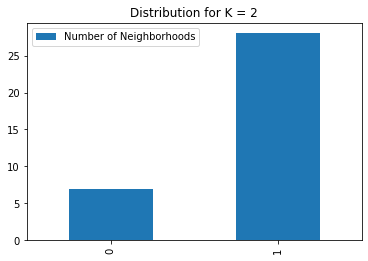

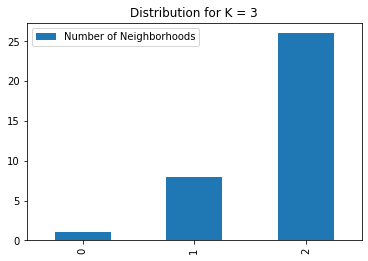

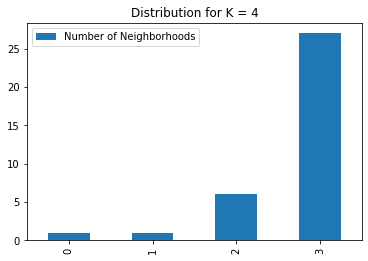

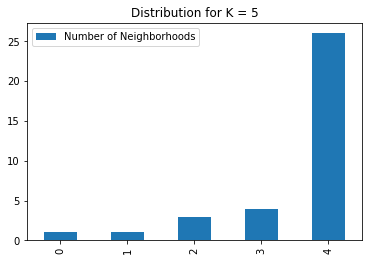

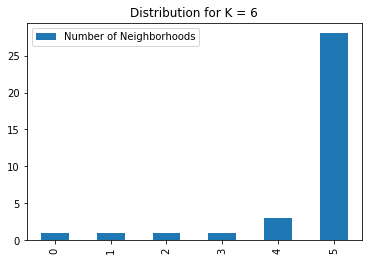

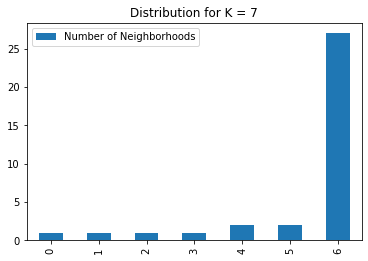

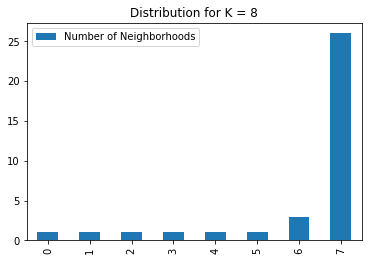

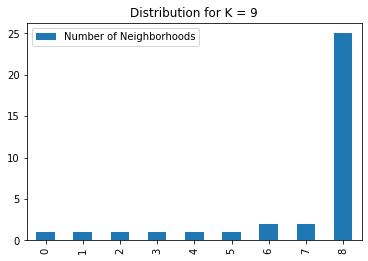

In [38]:
for k in range(2, 10):
    kmeans_test = KMeans(n_clusters=k, random_state = 0).fit(toronto_clusters)
    dft = pd.DataFrame(np.sort(np.unique(kmeans_test.labels_, return_counts=True)[1]), columns=['Number of Neighborhoods']).plot(kind='bar')
    plt.title(f'Distribution for K = {k}')
    plt.show()


Well, that's really interesting; there's a group of ~25 neighborhoods that KMeans thinks is extremely similar. Lets use k=4, as originally suggested, and graph these clusters.

In [39]:
neighborhoods.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))
toronto_merged = toronto_filtered
toronto_merged = toronto_merged.join(neighborhoods.set_index('Neighborhood'), on= 'Neighborhood' )
toronto_merged = toronto_merged.dropna(axis=0).astype({'Cluster Labels':np.int32})
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650295,-79.359166,2,Coffee Shop,Bakery,Boat or Ferry,Theater,Gastropub
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657363,-79.378180,2,Coffee Shop,Clothing Store,Japanese Restaurant,Middle Eastern Restaurant,Café
2,M5C,Downtown Toronto,St. James Town,43.651210,-79.375481,2,Coffee Shop,Café,Restaurant,Seafood Restaurant,Hotel
3,M4E,East Toronto,The Beaches,43.676531,-79.295425,2,Health Food Store,Pub,Trail,Neighborhood,Yoga Studio
4,M5E,Downtown Toronto,Berczy Park,43.645160,-79.373675,2,Coffee Shop,Seafood Restaurant,Restaurant,Beer Bar,Bakery


In [40]:
map_clusters = folium.Map(location = (latitude, longitude), zoom_start=12)

# Coloring scheme
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### That looks really interesting. Let's take a look at these clusters, in order of size, and see what commonalities we find in the venue distribution

#### Cluster 1

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]


,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th
0,"Regent Park, Harbourfront",Coffee Shop,Bakery,Boat or Ferry,Theater,Gastropub
1,"Garden District, Ryerson",Coffee Shop,Clothing Store,Japanese Restaurant,Middle Eastern Restaurant,Café
2,St. James Town,Coffee Shop,Café,Restaurant,Seafood Restaurant,Hotel
3,The Beaches,Health Food Store,Pub,Trail,Neighborhood,Yoga Studio
4,Berczy Park,Coffee Shop,Seafood Restaurant,Restaurant,Beer Bar,Bakery
5,Central Bay Street,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bubble Tea Shop,Plaza
6,Christie,Café,Grocery Store,Playground,Coffee Shop,Italian Restaurant
7,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Japanese Restaurant,Steakhouse
8,"Dufferin, Dovercourt Village",Park,Furniture / Home Store,Bank,Pet Store,Pharmacy
10,"Little Portugal, Trinity",Coffee Shop,Bar,Wine Bar,Restaurant,Cocktail Bar


Almost all of these places have cafes or coffee shops, as well as other varieties of eateries. We can infer that this constitutes the heart of Toronto's food scene.

#### Cluster 2

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th
9,"Harbourfront East, Union Station, Toronto Islands",Pier,Harbor / Marina,Park,Yoga Studio,Eastern European Restaurant
11,"The Danforth West, Riverdale",Bus Line,Grocery Store,Ice Cream Shop,Park,Discount Store
21,"High Park, The Junction South",Convenience Store,Park,Residential Building (Apartment / Condo),Sandwich Place,Dumpling Restaurant
22,North Toronto West,Playground,Gym Pool,Park,Garden,Eastern European Restaurant
28,"Moore Park, Summerhill East",Playground,Gym,Park,Tennis Court,Donut Shop
32,Rosedale,Playground,Grocery Store,Park,Candy Store,Eastern European Restaurant


Now, these places tend to all have parks, gyms, and playgrounds. These are likely more residential neighborhoods, where people live, work, and stay healthy.

#### Cluster 3

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th
30,"Summerhill West, Rathnelly, South Hill, Forest...",Coffee Shop,Light Rail Station,Supermarket,Liquor Store,Yoga Studio


This neighborhood is likely different from the others as, even though it has many coffee shops, it has a much more diffuse set of common venues, making it markedly unlike the neighborhoods in cluster 1.

#### Cluster 4

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th
20,Forest Hill North & West,Locksmith,Park,Yoga Studio,Electronics Store,Flea Market


Finally, this neighborhood has a locksmith and an electronics store, making it more of a blue-collar, industrial neighborhood, unlike the rest of the gentrified Old Toronto area.

## Conclusion

We used BeautifulSoup to parse the Toronto location data, plotted the neighborhoods of the city with geopy, and used the foursquare API to investigate the distribution of venues through Old Toronto.

Thank you so much for reading through this notebook, and good luck on your own capstone projects!